### Archive-compamps: Spectrogram conversion and basic statistical feature extraction

In [10]:
import sys
import re
from dateutil import parser
import glob
import math
import string
import time
import datetime
import cPickle as pickle
from io import BytesIO
from struct import unpack
from math import sqrt
import numpy as np
from numpy import fft
from scipy import stats
import matplotlib.pyplot as plt
from os import listdir
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pylab
from PIL.Image import fromarray
from IPython.display import FileLink, FileLinks
from IPython.display import Image, display, display_png

%matplotlib inline

In [11]:
# Setup Swift-Spark driver function
def config_hadoop(name, auth_url, username, password, auth_method='basic64'):
    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
#     hconf.setInt('fs.swift.blocksize', 32768)  # https://hadoop.apache.org/docs/stable/hadoop-openstack/index.html
#     hconf.setInt('fs.swift.partsize', 32768)
#     hconf.setInt('fs.swift.requestsize', 8080)
    hconf.setInt('fs.swift.connect.timeout', 15000)
    hconf.setInt('fs.swift.socket.timeout', 60000)
    hconf.setInt('fs.swift.connect.retry.count', 10)
#     hconf.setInt('fs.swift.connect.throttle.delay', 0)
    hconf.set(prefix + '.auth.url', auth_url)
    hconf.set(prefix + '.username', username)
    hconf.set(prefix + '.tenant', username)
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.apikey', password)
    hconf.setBoolean(prefix + '.public', False)
    hconf.set(prefix + '.use.get.auth', auth_method)
    hconf.setBoolean(prefix + '.location-aware', False)
    hconf.set(prefix + '.password', password)

In [12]:
def to_waterfall(raw_str):  # convert single or multi-subband compamps into waterfall feature strings
    rf_center_frequency, half_frame_number, activity_id, hz_per_subband, start_subband_id, \
    number_of_subbands, over_sampling, polarization = unpack('>diidiifi', raw_str[:40])  # read header

    half_frame_bytes = number_of_subbands * 512 + 40  # MAX_SUBBAND_BINS_PER_1KHZ_HALF_FRAME = 512
    number_of_half_frames = len(raw_str) / half_frame_bytes

    arr = np.frombuffer(raw_str, dtype=np.int8)\
        .reshape((number_of_half_frames, half_frame_bytes))  # create array of half frames
    arr = arr[::-1, 40:]  # slice out 40 byte header and flip half frame order to comply with waterfall format
    arr = arr.reshape((number_of_half_frames*(half_frame_bytes-40))) # compact into vector

    real_val = np.bitwise_and(arr, 0xf0).astype(np.int8)  # coef's are: RRRRIIII (4 bits real,
    imag_val = np.left_shift(np.bitwise_and(arr, 0x0f), 4).astype(np.int8)  # 4 bits imaginary in 2's complement)

    coef = np.empty(len(real_val), complex)
    coef.real = np.right_shift(real_val, 4)
    coef.imag = np.right_shift(imag_val, 4)

    arr = coef.reshape((number_of_half_frames, number_of_subbands, 512))  # expose compamp measurement blocks

    arr = fft.fftshift(fft.fft(arr), 2)  # FFT all blocks separately and rearrange output
    arr = arr[:, :, (512*over_sampling/2):-(512*over_sampling/2)]  # slice out oversampled frequencies

    # normalize and amplify by factor 15, join subbands into extended frequency range
    arr = np.clip(np.multiply(np.square(np.abs(arr)), 15.0/512), 0, 255)\
        .reshape((arr.shape[0], arr.shape[1]*arr.shape[2]))
#         .astype(np.uint8)  # allow for direct PNG output
    
    return (round(rf_center_frequency, 3), half_frame_number, activity_id, round(hz_per_subband, 3),
                start_subband_id, number_of_subbands, over_sampling, polarization, arr.shape[0], arr.shape[1],
                round(np.mean(np.mean(arr, 0)), 3), 
                round(np.mean(np.std(arr, 0)), 3), 
                round(np.mean(np.std(arr, 1)), 3) 
              )
#     round(np.mean(np.mean(arr, 0)), 3) -> Mean of mean over first dimension of waterfall plot
#     round(np.mean(np.std(arr, 0)), 3) -> Mean of std.dev. over first dimension of waterfall plot
#     round(np.mean(np.std(arr, 1)), 3) -> Mean of std.dev. over second dimension of waterfall plot

CPU times: user 766 ms, sys: 147 ms, total: 913 ms
Wall time: 1h 9min 58s
401626


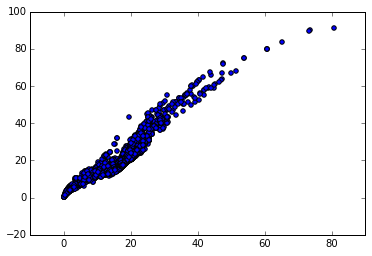

In [14]:
# CONFIDENTIAL - Object Store access setup - change first parameter (name) throughout when stale errors occur
config_hadoop('compamps','https://dal05.objectstorage.service.networklayer.com/auth/v1.0',
              'IBMOS294544-4:npoore@us.ibm.com','abde9540378cd1e662de10df155ea50ccd88a6137af5575cc639957e6b635b7d', 'true')

# link 256MB chunk objects into RDD, each object is a cPickle of a list of ACAs (archive compamp)
# ACAs are usually 1,061,928 bytes, but are combined to reduce Spark MapReduce overhead
# (128/256MB chunks appear to be optimal)
compamps = sc.binaryFiles('swift://archcompamp-20130101-20150328-v1-256MB-v1.compamps/*')

# unpickle each object to list and split list into separate compamp files (flatMap)
ufeats = compamps.map(lambda p: pickle.loads(p[1])).flatMap(lambda p: p)

# some compamps are corrupt/non-compliant from source, filter them out, 
# process each compamp file (map) and extract mean-stddev features
feats = ufeats.filter(lambda p: len(p[1])==1061928).map(lambda p: to_waterfall(p[1])[10:12])

%time featsxy = np.array(feats.collect())  # collect all mean-stddev features into local memory and convert to Numpy array
print len(featsxy)  # how many samples are there?
plt.scatter(featsxy[:, 0], featsxy[:, 1])  # scatter plot two mean-stddev features
plt.show()